# Exploratory data analysis HUPA-UCM Diabetes 
<br>**Participantes**<br>
- Morales Martinez Arturo 
- Moreno Santa Maria Luis Daniel

<br>**Dataset:**<br>
- Origen : Universidad de Madrid
<br>**Sensores:**<br>
- Freestle libre 2 for the Continuous Glucose Monitoring
- Fitbit Ionic smartwatches for the other variables (steps, calories, heartrate \& sleepdata)
<br>**Variables:**<br>
- time: time of data recording (yyyy-MM-dd’T’HH:mm:ss format)
- glucose: blood glucose value (mg/dL)
- calories: calories burned in the time Interval
- heart_rate: heart frequency
- steps: steps taken in the time interval
- basal_rate: basal insulin infusions in the time interval
- bolus_volume_delivered: insulin bolus injections in the time interval
- carb_input: servings of carbohydrates ingested in the time interval (1 serving = 10 g)

## Libraries & Configuration

In [377]:
# Miscellaneous Funcionality
import os, glob
import re
import datetime

# ETL
import numpy as np
import pandas as pd


# Visualization
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Math
import math
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.api import tsa

In [378]:
# plot customization hyperparameters
sns.set_theme()
size = 2
a = .6 # alpha = transparencia
scale = 1
width = 6 * scale # 21cm - 5cm = 16 cm = 6.3 inches * scale
flierprops = dict(marker = "+", color = "r", alpha = .5)
deep_blue = "#4C72B0"

In [379]:
data_dir = 'HUPA-UCM Diabetes Dataset/Preprocessed'
hour = 12
day = 288

## Exploratory Data Analysis

### Preprocessed data

In [450]:
# clinical characterization
sex = [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0] # 0 : female, 1 : male
age = [56.3, 48.6, 43.4, 41.2, 41.9, 22.1, 37.6, 41.2, 41.9, 35, 50, 43.1, 29.9, 26.3, 32.3, 18, 45.7, 48.6, 59.6, 22.9, 47.9, 38.1, 61.8, 26.4, 21.2] # age
dxtime = [15.5, 36.5, 12.5, 8.5, 39.5, 13.5, 10.1, 30.7, 15.2, 27.3, 12.9, 11.2, 20.1, 24.2, 25.6, 7.6, 13.5, 2.2, 14.6, 0.8, 35.9, 20.3, 21.5, 23.7, 2] # disease time

In [439]:
# Append all the patients onto a single dataframe
people = []
path = "HUPA-UCM Diabetes Dataset/Preprocessed/"
id = 0 
for filename, sex, age, dxtime in zip(glob.glob(os.path.join(path, '*.csv')), sex, age, dxtime):
    df = pd.read_csv(filename, sep = ";")
    df["time"] = df["time"].apply(lambda x: np.datetime64(x))
    df["sex"] = sex
    df["age"] = age
    df["dxtime"] = dxtime 
    df["patient_id"] = [id for i in range(len(df))]
    # df = df.set_index(['patient_id', 'time'])
    people.append(df)
     # id += 1

In [382]:
# t_(i) - t_(i-1)
def diff(ts):
    new_ts = []
    for i in range(1,len(ts)):
        value = ts[i] - ts[i - 1]
        new_ts.append(value)
    return new_ts

In [383]:
# differenciate the dataframes

diff1_people = []
for person in people:
    person = person.drop(columns = ["time", "sex", "age", "dxtime", "patient_id"])
    diff1_columns = []
    cols = person.columns
    for column in cols:
        diff1_column = diff(person[column])
        diff1_columns.append(diff1_column)
    diff1_person = pd.DataFrame(data  = {
        'glucose' : diff1_columns[0],
        'calories' : diff1_columns[1],
        'heart_rate' : diff1_columns[2],
        'steps' : diff1_columns[3],
        'basal_rate' : diff1_columns[4],
        'bolus_volume_delivered' : diff1_columns[5],
        'carb_input' : diff1_columns[6]
    })
    diff1_people.append(diff1_person)

diff2_people = []
for diff1_person in diff1_people:
    diff2_columns = []
    for column in cols:
        diff2_column = diff(diff1_person[column])
        diff2_columns.append(diff2_column)
    diff2_person = pd.DataFrame(data  = {
        'glucose' : diff2_columns[0],
        'calories' : diff2_columns[1],
        'heart_rate' : diff2_columns[2],
        'steps' : diff2_columns[3],
        'basal_rate' : diff2_columns[4],
        'bolus_volume_delivered' : diff2_columns[5],
        'carb_input' : diff2_columns[6]
    })
    diff2_people.append(diff2_person)

In [440]:
df = pd.concat(people)
df_d1 = pd.concat(diff1_people)
df_d2 = pd.concat(diff2_people)

#### Rows per pacient

In [385]:
# Find patient's number
def find_number_string(string):
    numbers = re.findall(r'\d+', string)
    return numbers

In [386]:
# The following cell is intended to get a dictionary where each key is the patient's id amd the value the number of rows 
patients = {int(find_number_string(os.path.join(data_dir, filename))[0]) : pd.read_csv(os.path.join(data_dir, filename), sep=';').shape[0]
                   for filename in os.listdir(data_dir)}

# Just to sort by the amount of rows
patients = dict(sorted(patients.items(), key=lambda item: item[1]))

In [387]:
# Now, just tabulate days, months and year per patient
table = [] 
for key, value in patients.items():
    days = value / day
    months = days / 30
    years = months / 12
    table.append([key, value, days, months, years])
print(tabulate(table, headers=["Patient", "Rows", "Days", "Months", "Years"], tablefmt="grid"))

+-----------+--------+-----------+-----------+-----------+
|   Patient |   Rows |      Days |    Months |     Years |
+===========+========+===========+===========+===========+
|         6 |   2290 |   7.95139 |  0.265046 | 0.0220872 |
+-----------+--------+-----------+-----------+-----------+
|        18 |   2343 |   8.13542 |  0.271181 | 0.0225984 |
+-----------+--------+-----------+-----------+-----------+
|        17 |   2862 |   9.9375  |  0.33125  | 0.0276042 |
+-----------+--------+-----------+-----------+-----------+
|        21 |   2902 |  10.0764  |  0.33588  | 0.02799   |
+-----------+--------+-----------+-----------+-----------+
|         9 |   2976 |  10.3333  |  0.344444 | 0.0287037 |
+-----------+--------+-----------+-----------+-----------+
|         2 |   3181 |  11.0451  |  0.368171 | 0.0306809 |
+-----------+--------+-----------+-----------+-----------+
|         4 |   3184 |  11.0556  |  0.368519 | 0.0307099 |
+-----------+--------+-----------+-----------+----------

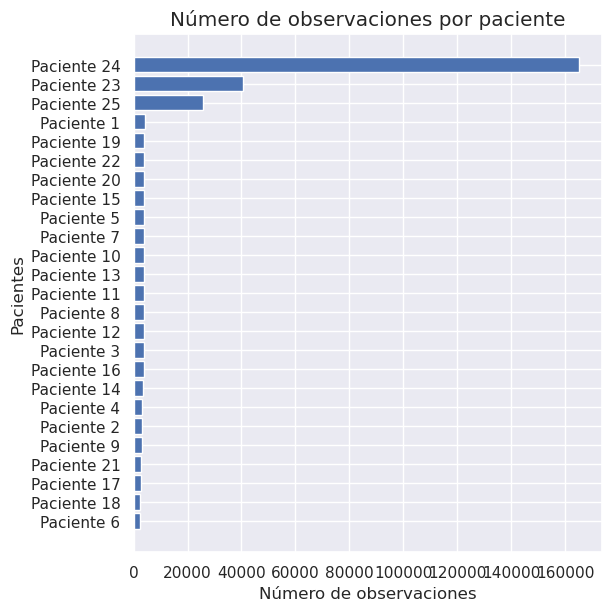

In [388]:
plt.figure(figsize=(width, width), layout = "constrained")
plt.barh([f'Paciente {key}' for key, value in patients.items()], [value for key, value in patients.items()])
plt.xlabel('Número de observaciones', fontsize = "medium")
plt.ylabel('Pacientes', fontsize = "medium")
plt.grid(True)
plt.title('Número de observaciones por paciente', fontsize = "large")
plt.savefig('Images/n_observaciones_por_paciente')

La persona con menos observaciones, tiene 7 días de monitoreo. la mayoría ronda entre las 2 semanas

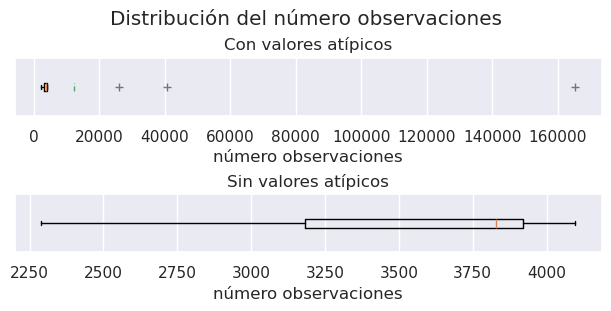

In [389]:
lengths = [len(person) for person in people]
fig, axs = plt.subplots(2, 1, figsize = (width,width/2), layout = "constrained")
axs[0].boxplot(lengths, showfliers = True, orientation = "horizontal",showbox = True, flierprops = flierprops, showmeans = True, meanline = True)
axs[0].set_xlabel("número observaciones")
axs[0].set_yticks([])
axs[0].set_title("Con valores atípicos") # Atipycal values : v > Q3 + 1.5 RIC 
axs[1].boxplot(lengths, showfliers = False, orientation = "horizontal",showbox = True, flierprops = flierprops)
axs[1].set_xlabel("número observaciones")
axs[1].set_yticks([])
axs[1].set_title("Sin valores atípicos")
plt.suptitle("Distribución del número observaciones", fontsize = "large")
plt.savefig("Images/distribucion_n_observaciones.png", format = "png")
plt.show()

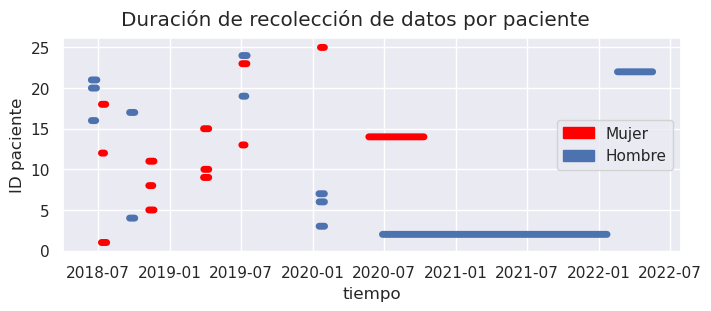

In [390]:
fig, ax = plt.subplots(figsize = (width + 1, width / 2), layout = "constrained")
i = 1
for person in people:
    line = [i for j in range(len(person))]
    if all(person["sex"] == 0):
        plt.plot(person.time, line, linewidth = 5, color = "red")
    else:
        plt.plot(person.time, line, linewidth = 5, color = deep_blue)
    i += 1
ax.set_xlabel("tiempo")
ax.set_ylabel("ID paciente")
fig.suptitle("Duración de recolección de datos por paciente")
red_patch = mpatches.Patch(color='red', label='Mujer')
blue_patch = mpatches.Patch(color=deep_blue, label='Hombre')
plt.legend(handles = [red_patch, blue_patch])
plt.savefig("Images/duracion_recoleccion_paciente.png", format = "png")
plt.show()

#### Análisis univariado de glucosa

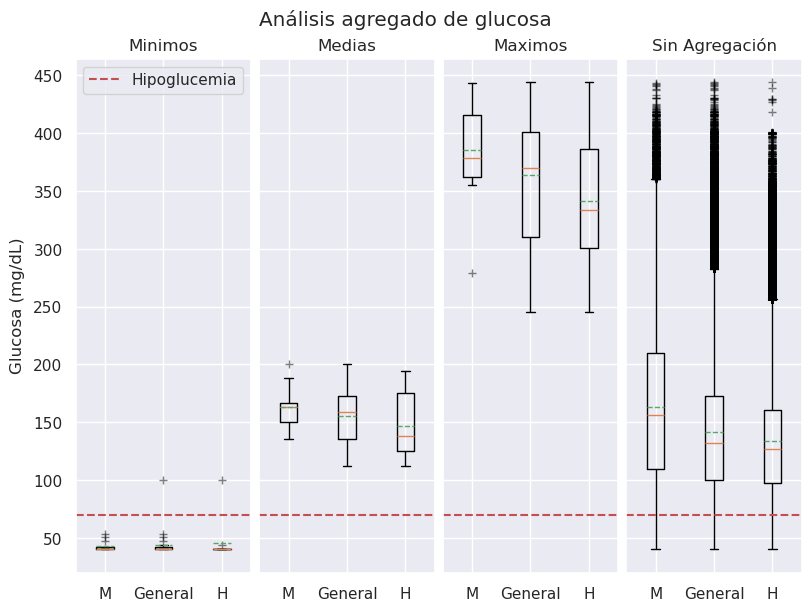

In [391]:
minsf = []
maxsf = []
meansf = []
minsm = []
maxsm = []
meansm = []
mins = []
means = []
maxs = []
f = df[df["sex"] == 0]
m = df[df["sex"] == 1]

for person in people:
    glucose = person["glucose"]
    mins.append(min(glucose))
    maxs.append(max(glucose))
    means.append(glucose.mean())
    if all(person["sex"]) == 0:
        minsf.append(min(glucose))
        maxsf.append(max(glucose))
        meansf.append(glucose.mean())
    else:
        minsm.append(min(glucose))
        maxsm.append(max(glucose))
        meansm.append(glucose.mean())

fig, axs = plt.subplots(1, 4, figsize = (width+2,width), sharey = True, layout = "constrained")
axs[0].boxplot([minsf, mins, minsm], tick_labels = ["M", "General", "H"], flierprops = flierprops, showmeans = True, meanline = True)
axs[0].set_title("Minimos", fontsize = "medium")
axs[0].axhline(70, color = "r", ls = "--", label = "Hipoglucemia")
axs[0].legend()
axs[1].boxplot([meansf, means, meansm], tick_labels = ["M", "General", "H"], flierprops = flierprops, showmeans = True, meanline = True)
axs[1].axhline(70, color = "r", ls = "--", label = "Hipoglucemia")
axs[1].set_title("Medias", fontsize = "medium")
axs[2].boxplot([maxsf, maxs, maxsm], tick_labels = ["M", "General", "H"], flierprops = flierprops, showmeans = True, meanline = True)
axs[2].set_title("Maximos", fontsize = "medium")
axs[2].axhline(70, color = "r", ls = "--", label = "Hipoglucemia")
axs[3].boxplot([f["glucose"], df["glucose"], m["glucose"]], tick_labels = ["M", "General", "H"], flierprops = flierprops, showmeans = True, meanline = True)
axs[3].set_title("Sin Agregación", fontsize = "medium")
axs[3].axhline(70, color = "r", ls = "--", label = "Hipoglucemia")

plt.suptitle("Análisis agregado de glucosa", fontsize = "large")
fig.supylabel("Glucosa (mg/dL)", fontsize = "medium")
plt.savefig("Images/agregados_glucosa_separados.png", format = "png")
plt.show()

In [467]:
boxdata = zip(age, sex)
boxdata = pd.DataFrame(boxdata, columns = ["age", "sex"])
fbp = boxdata[boxdata["sex"] == 0]
mbp = boxdata[boxdata["sex"] == 1]

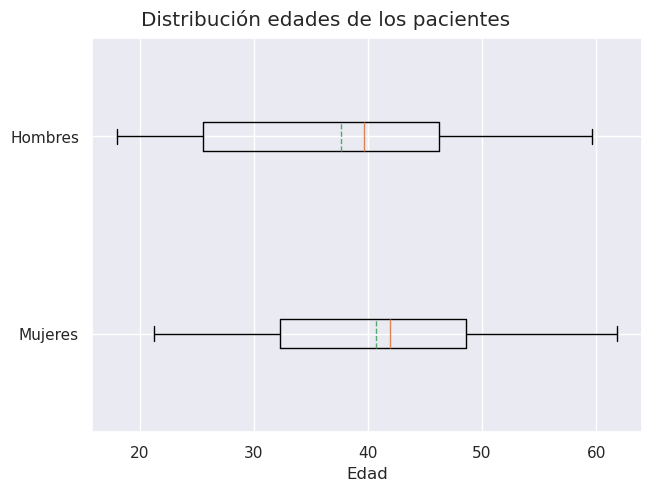

In [469]:
fig, ax = plt.subplots(layout = "constrained")
ax.boxplot([fbp["age"], mbp["age"]], tick_labels = ["Mujeres", "Hombres"], showfliers = True, orientation = "horizontal", showbox = True, flierprops = flierprops, showmeans = True, meanline = True)
ax.set_xlabel("Edad")
plt.suptitle("Distribución edades de los pacientes", fontsize = "large")
plt.savefig("Images/distribucion_edades_pacientes.png", format = "png")
plt.show()

In [392]:
# h0 : no hay diferencia entre los niveles de glucosa entre mujeres y hombres : mu_mujeres - mu_hombres = 0 
# ha : hay una diferencia entee los niveles de glucosa entre mujeres y hombres : mu_mujeres - mu_hombres != 0 
# prueba t de 2 muestras a dos colas
res = stats.ttest_ind(f["glucose"], m["glucose"], equal_var= False) # two samples with different sizes
mins_res = stats.ttest_ind(minsf, minsm, equal_var= False)
means_res = stats.ttest_ind(meansf, meansm, equal_var= False)
maxs_res = stats.ttest_ind(maxsf, maxsm, equal_var= False)

# Define headers and data
headers = ["Métrica", "Estadístico", "Valor p", "Grados de libertad"]
table = [
    ["General", res.statistic, res.pvalue, res.df],
    ["Mínimos", mins_res.statistic, mins_res.pvalue, mins_res.df],
    ["Medias", means_res.statistic, means_res.pvalue, means_res.df],
    ["Máximos", maxs_res.statistic, maxs_res.pvalue, maxs_res.df]
]

# Print the table
print(tabulate(table, headers=headers, tablefmt="grid"))
print(f"cantidad de muestras femeninas : {len(f)}")
print(f"cantidad de mujeres : {len(minsf)}")
print(f"cantidad de muestras masculinas : {len(m)}")
print(f"cantidad de hombres : {len(minsm)}")

+-----------+---------------+-----------+----------------------+
| Métrica   |   Estadístico |   Valor p |   Grados de libertad |
+===========+===============+===========+======================+
| General   |     112.851   | 0         |          111801      |
+-----------+---------------+-----------+----------------------+
| Mínimos   |      -0.49904 | 0.62648   |              12.41   |
+-----------+---------------+-----------+----------------------+
| Medias    |       1.58328 | 0.130962  |              17.8007 |
+-----------+---------------+-----------+----------------------+
| Máximos   |       2.12843 | 0.0454794 |              20.708  |
+-----------+---------------+-----------+----------------------+
cantidad de muestras femeninas : 80763
cantidad de mujeres : 13
cantidad de muestras masculinas : 228629
cantidad de hombres : 12


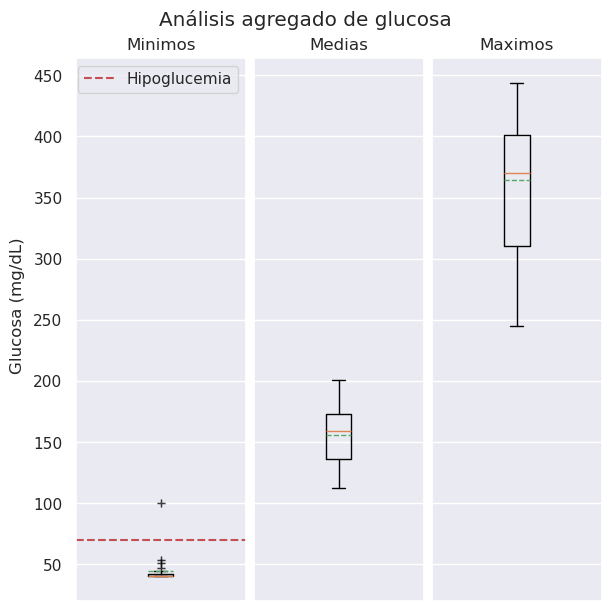

In [393]:
for person in people:
    glucose = person["glucose"]
    mins.append(min(glucose))
    maxs.append(max(glucose))
    means.append(glucose.mean())

fig, axs = plt.subplots(1, 3, figsize = (width,width), sharey = True, layout = "constrained")
axs[0].boxplot(mins, flierprops = flierprops, showmeans = True, meanline = True)
axs[0].set_title("Minimos", fontsize = "medium")
axs[0].axhline(70, color = "r", ls = "--", label = "Hipoglucemia")
axs[0].set_xticks([])
axs[0].legend()
axs[1].boxplot(means, showmeans = True, meanline = True)
axs[1].set_title("Medias", fontsize = "medium")
axs[1].set_xticks([])
axs[2].boxplot(maxs, showmeans = True, meanline = True)
axs[2].set_title("Maximos", fontsize = "medium")
axs[2].set_xticks([])
plt.suptitle("Análisis agregado de glucosa", fontsize = "large")
fig.supylabel("Glucosa (mg/dL)", fontsize = "medium")
plt.savefig("Images/agregados_glucosa.png", format = "png")
plt.show()

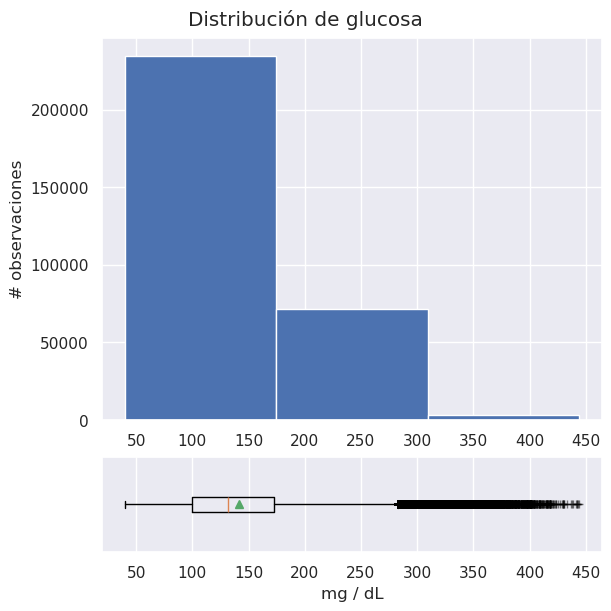

In [394]:
# Glucose distribution
glucose = df["glucose"]
fig, axs = plt.subplots(2,1, gridspec_kw = {'height_ratios': [4, 1]}, figsize = (width, width), layout = "constrained")
# bins are calculated Freedman–Diaconis rule
bins = (2 * stats.iqr(glucose) / (len(glucose)) ** (1/3))
axs[0].hist(glucose, bins = math.ceil(bins))
axs[0].set_ylabel("# observaciones")
axs[1].boxplot(glucose, orientation = "horizontal", flierprops = flierprops, showmeans = True)
axs[1].set_xlabel("mg / dL")
axs[1].set_yticks([])
plt.suptitle("Distribución de glucosa")
plt.savefig("Images/distribucion_de_glucosa.png", format = "png")
plt.show()

### Análisis Multivariado

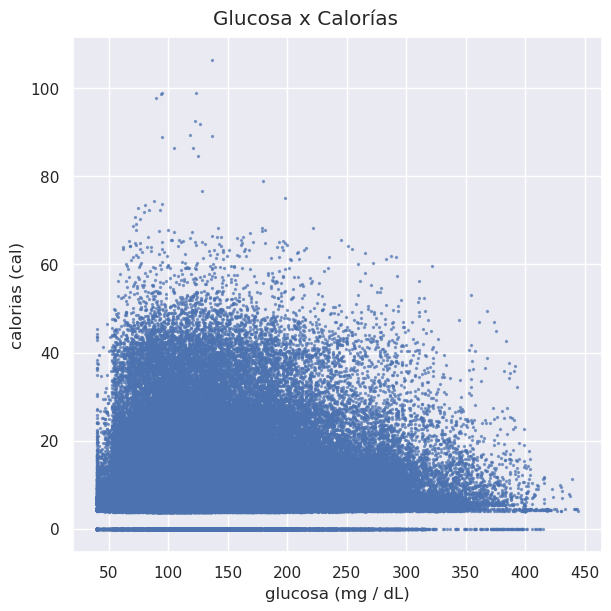

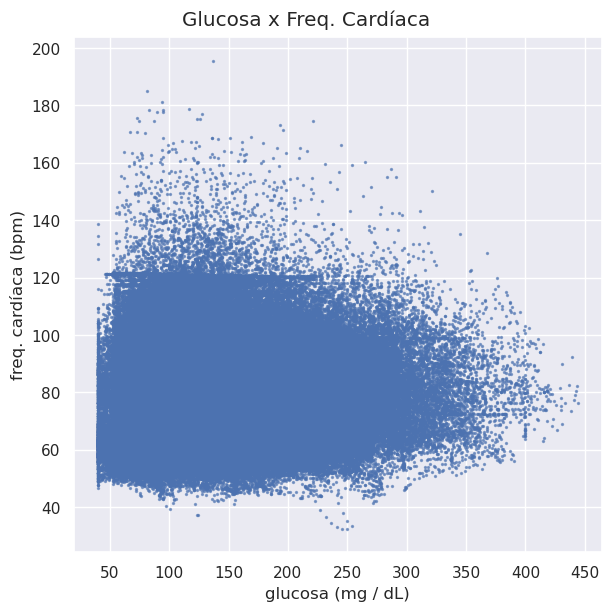

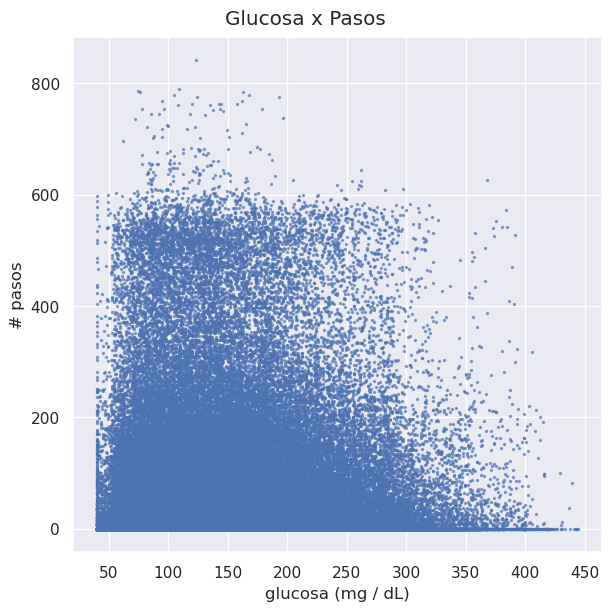

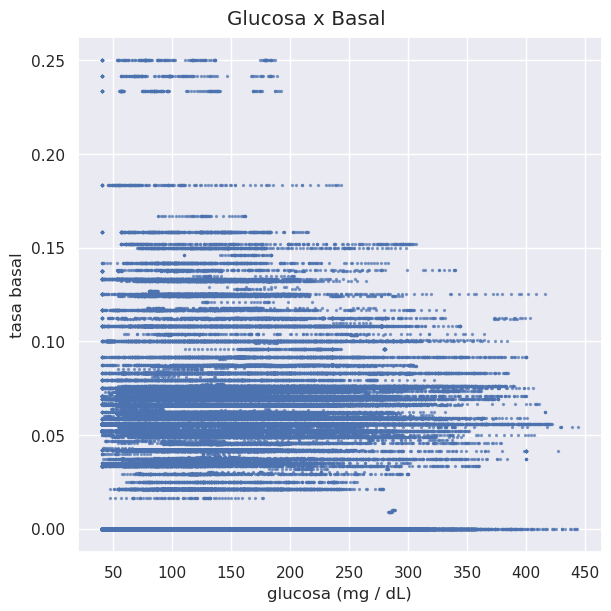

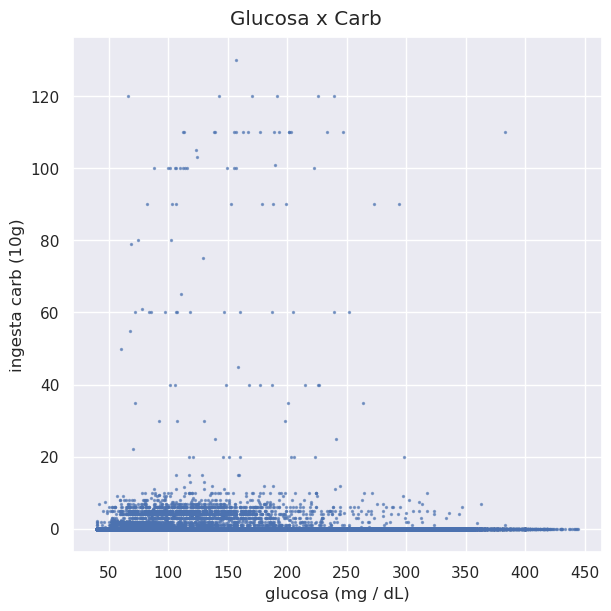

In [395]:
fig, ax = plt.subplots(figsize = (width, width), layout = "constrained")
ax.scatter(glucose, df["calories"], alpha = a, s = size)
ax.set_ylabel("calorias (cal)", fontsize = "medium")
ax.set_xlabel("glucosa (mg / dL)", fontsize = "medium")
fig.suptitle("Glucosa x Calorías", fontsize = "large")
plt.savefig("Images/glucosa_caloria.png", format = "png")
plt.show()

fig, ax = plt.subplots(figsize = (width, width), layout = "constrained")
ax.scatter(glucose, df["heart_rate"], alpha = a, s = size)
ax.set_ylabel("freq. cardíaca (bpm)", fontsize = "medium")
ax.set_xlabel("glucosa (mg / dL)", fontsize = "medium")
fig.suptitle("Glucosa x Freq. Cardíaca", fontsize = "large")
plt.savefig("Images/glucosa_freqcard.png", format = "png")
plt.show()

fig, ax = plt.subplots(figsize = (width, width), layout = "constrained")
ax.scatter(glucose, df["steps"], alpha = a, s = size)
ax.set_ylabel("# pasos", fontsize = "medium")
ax.set_xlabel("glucosa (mg / dL)", fontsize = "medium")
fig.suptitle("Glucosa x Pasos", fontsize = "large")
plt.savefig("Images/glucosa_pasos.png", format = "png")
plt.show()

fig, ax = plt.subplots(figsize = (width, width), layout = "constrained")
ax.scatter(glucose, df["basal_rate"], alpha = a, s = size)
ax.set_ylabel("tasa basal", fontsize = "medium")
ax.set_xlabel("glucosa (mg / dL)", fontsize = "medium")
fig.suptitle("Glucosa x Basal", fontsize = "large")
plt.savefig("Images/glucosa_basal.png", format = "png")
plt.show()

fig, ax = plt.subplots(figsize = (width, width), layout = "constrained")
ax.scatter(glucose, df["carb_input"], alpha = a, s = size)
ax.set_ylabel("ingesta carb (10g)", fontsize = "medium")
ax.set_xlabel("glucosa (mg / dL)", fontsize = "medium")
fig.suptitle("Glucosa x Carb", fontsize = "large")
plt.savefig("Images/glucosa_carb.png", format = "png")
plt.show()


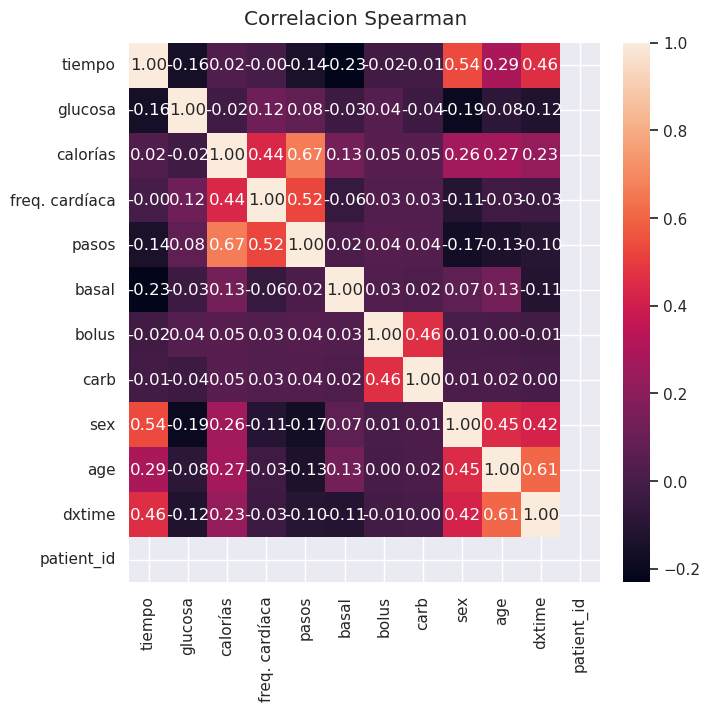

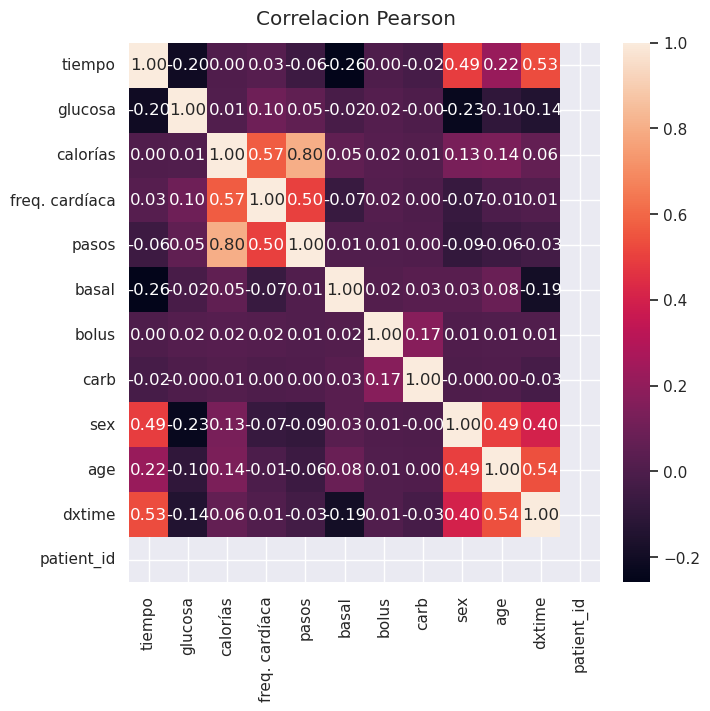

In [396]:
df_heatmap = df.copy()
df_heatmap = df_heatmap.rename(columns={
    "time" : "tiempo",
    "glucose" : "glucosa",
    "calories" : "calorías",
    "heart_rate" : "freq. cardíaca",
    "steps" : "pasos",
    "basal_rate" : "basal",
    "bolus_volume_delivered" : "bolus",
    "carb_input" : "carb",
    })
fig, ax = plt.subplots(figsize = (width + 1,width + 1), layout = "constrained")
sns.heatmap(df_heatmap.corr(method = "spearman"), annot = True, fmt=".2f")
plt.suptitle("Correlacion Spearman")
plt.savefig("Images/correlacion_spearman.png", format = "png")
plt.show()

fig, ax = plt.subplots(figsize = (width + 1,width + 1), layout = "constrained")
sns.heatmap(df_heatmap.corr(method = "pearson"), annot = True, fmt=".2f")
plt.suptitle("Correlacion Pearson")
plt.savefig("Images/correlacion_pearson.png", format = "png")
plt.show()

#### Time plots

In [397]:
# computing acf & pacf over a period of 3 days
nlags = day * 3 + 24 # 3 días + 2 horas
acfs = []
pacfs = []
for person in people:
    acf = tsa.stattools.acf(person["glucose"], nlags = nlags)
    pacf = tsa.stattools.pacf(person["glucose"], nlags = nlags)
    acfs.append(acf)
    pacfs.append(pacf)
acfs = np.array(acfs)
pacfs = np.array(pacfs)

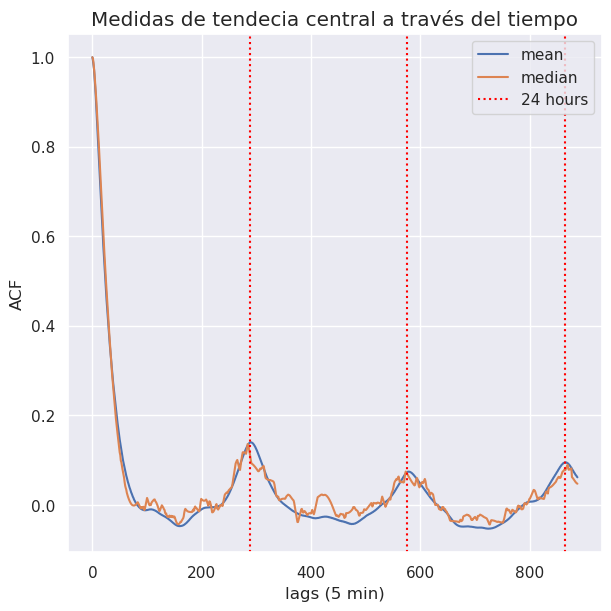

In [398]:
fig, ax = plt.subplots(figsize = (width, width), layout = "constrained")
plt.plot([acfs[:, i].mean() for i in range(nlags)], label = "mean")
plt.plot([np.median(acfs[:, i]) for i in range(nlags)], label = "median")
plt.ylabel("ACF", fontsize = "medium")
plt.xlabel("lags (5 min)", fontsize = "medium")
plt.title("Medidas de tendecia central a través del tiempo", fontsize = "large")
plt.axvline(x = day, ls = ":", color = "red", label = "24 hours")
plt.axvline(x = day * 2, ls = ":", color = "red")
plt.axvline(x = day * 3, ls = ":", color = "red")
plt.legend(loc = "upper right")
plt.savefig("Images/medidas_acf_74_horas.png", format = "png")
plt.show()

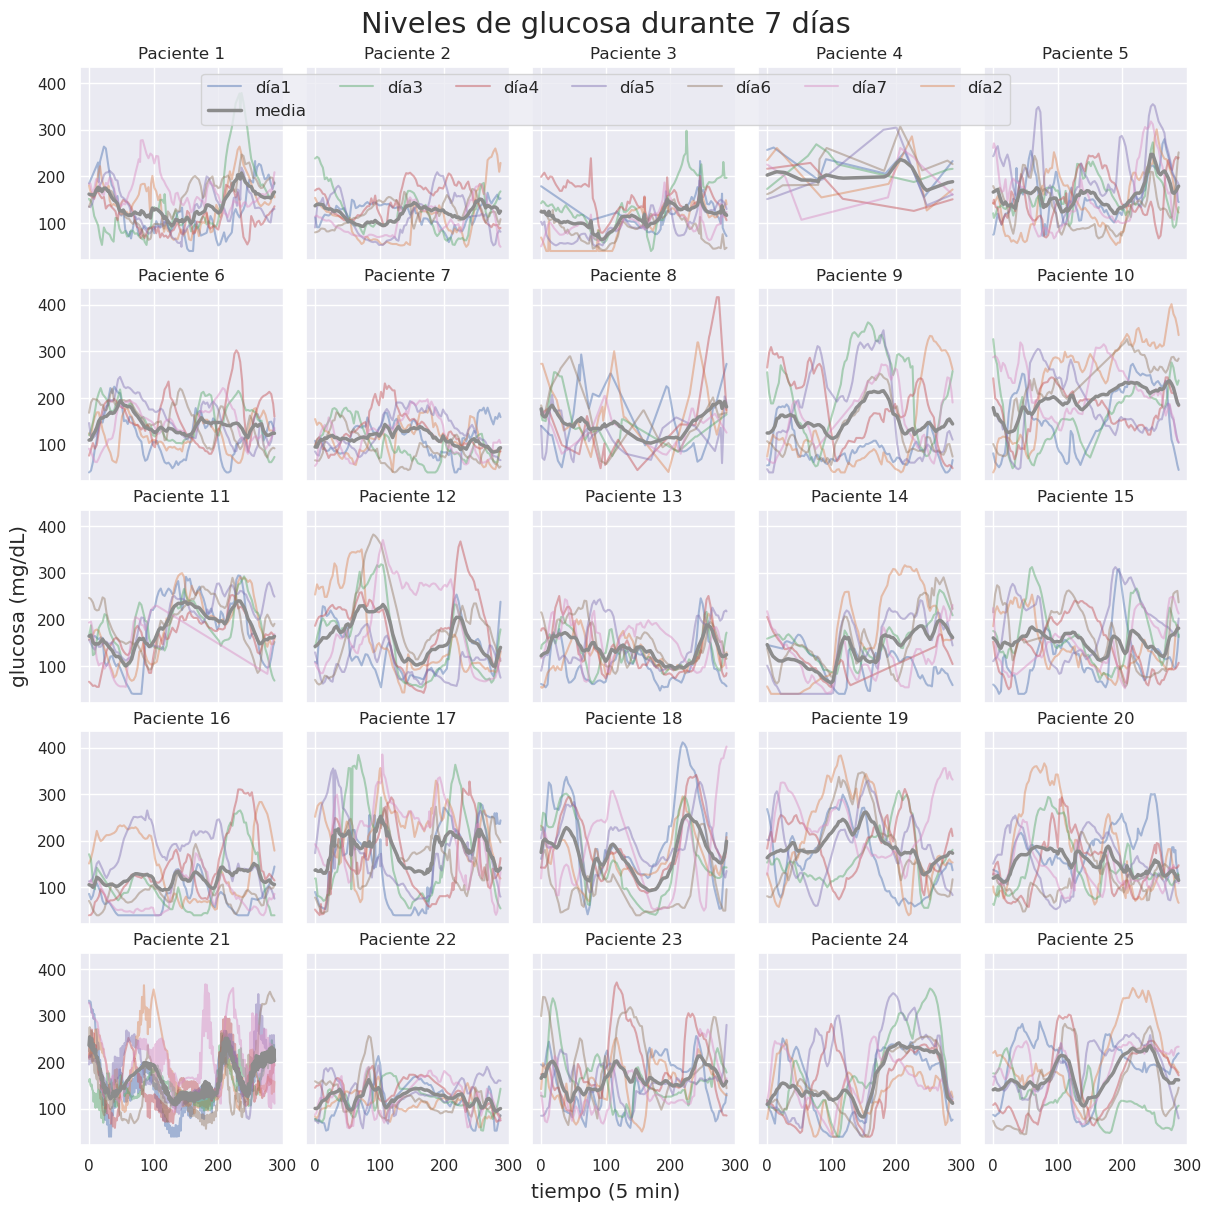

In [399]:
# Seasonal plot

# Aux function for the legend
def swap(arr, index1, index2):
    arr[index1], arr[index2] = arr[index2], arr[index1]
    return arr

# Obtain "season" = "day"
day_w = 288
patients_week = []

for person in people:
    glucose_w = person["glucose"]
    patient_week = [
        glucose_w[day_w * i : day_w * (i + 1)].reset_index(drop=True)
        for i in range(7)
    ]
    patients_week.append(patient_week)

pw = np.array(patients_week)

# plot
fig, axs = plt.subplots(5, 5, figsize = (width * 2, width * 2), sharey = True, sharex = True, layout = "constrained")
patient = 0
for i in range(5):
    for j in range(5):
        for day_w in range(7):
            axs[i, j].plot(patients_week[patient][day_w], alpha = a-.15, label = f"día{day_w + 1}")
            axs[i, j].set_title(f"Paciente {patient + 1}")
        axs[i, j].plot([pw[patient,:, i].mean() for i in range(day)], label = "media", lw = 2.5)
        patient += 1

handles, labels = axs[0, 0].get_legend_handles_labels()
handles = swap(handles, 1, -1)
labels = swap(labels, 1, -1)
fig.suptitle("Niveles de glucosa durante 7 días", fontsize = "xx-large")
fig.legend(handles, labels, ncol = 7, fontsize = "medium", loc='upper center', bbox_to_anchor=(0.5, 0.95))
fig.supylabel("glucosa (mg/dL)", fontsize = "large")
fig.supxlabel("tiempo (5 min)", fontsize = "large")
plt.savefig("Images/estacional_7_dias.png", format = "png")
plt.show()

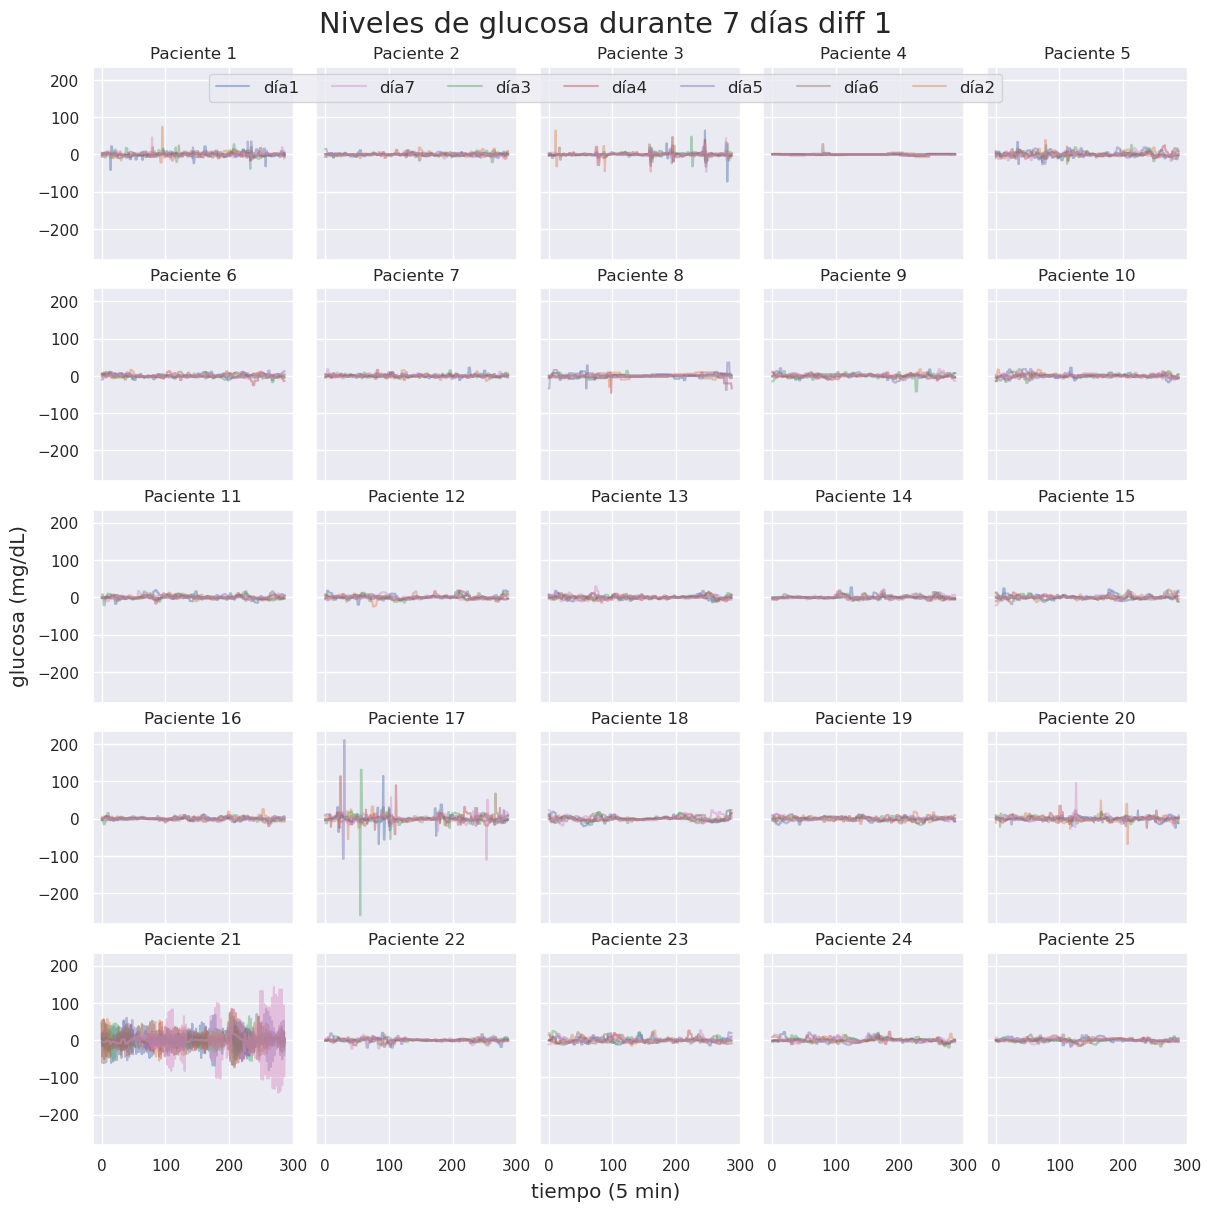

In [400]:
def swap(arr, index1, index2):
    arr[index1], arr[index2] = arr[index2], arr[index1]
    return arr

# Obtain "season" = "day"
day_w = 288
patients_week = []

for person in people:
    glucose_w = person["glucose"].diff().dropna()
    patient_week = [
        glucose_w[day_w * i : day_w * (i + 1)].reset_index(drop=True)
        for i in range(7)
    ]
    patients_week.append(patient_week)

pw = np.array(patients_week)

# plot
fig, axs = plt.subplots(5, 5, figsize = (width * 2, width * 2), sharey = True, sharex = True, layout = "constrained")
patient = 0
for i in range(5):
    for j in range(5):
        for day_w in range(7):
            axs[i, j].plot(patients_week[patient][day_w], alpha = a-.15, label = f"día{day_w + 1}")
            axs[i, j].set_title(f"Paciente {patient + 1}")
        patient += 1

handles, labels = axs[0, 0].get_legend_handles_labels()
handles = swap(handles, 1, -1)
labels = swap(labels, 1, -1)
fig.suptitle("Niveles de glucosa durante 7 días diff 1", fontsize = "xx-large")
fig.legend(handles, labels, ncol = 7, fontsize = "medium", loc='upper center', bbox_to_anchor=(0.5, 0.95))
fig.supylabel("glucosa (mg/dL)", fontsize = "large")
fig.supxlabel("tiempo (5 min)", fontsize = "large")
plt.savefig("Images/estacional_7_dias_diff1.png", format = "png")
plt.show()

Se observan tendencias ligeras en los pacientes

In [401]:
# Initialize 2x2 result matrix
# Rows: ADF (0 = fail, 1 = pass)
# Columns: KPSS (0 = fail, 1 = pass)
# Quadrants: 
# [ [ADF no, KPSS no],     [ADF no, KPSS yes] ]
# [ [ADF yes, KPSS no],    [ADF yes, KPSS yes] ]
result_matrix = np.zeros((2, 2), dtype=int)
not_kpss = []
for i, df in enumerate(people):
    glucose_series = df["glucose"]

    # ADF Test
    adf_result = adfuller(glucose_series)
    adf_pvalue = adf_result[1]
    adf_pass = adf_pvalue < 0.05

    # KPSS Test
    try:
        kpss_result = kpss(glucose_series, regression='c', nlags='auto')
        kpss_pvalue = kpss_result[1]
        kpss_pass = kpss_pvalue > 0.05
        if not kpss_pass:
            not_kpss.append(i)
    except ValueError:
        kpss_pass = False  # Assume failure if KPSS test fails

    # Map boolean values to indices (0 or 1)
    adf_index = int(adf_pass)
    kpss_index = int(kpss_pass)

    # Increment corresponding cell
    result_matrix[adf_index, kpss_index] += 1

# Display matrix as a confusion-matrix-like table
confusion_df = pd.DataFrame(
    result_matrix,
    index=["ADF Fail", "ADF Pass"],
    columns=["KPSS Fail", "KPSS Pass"]
)

print(confusion_df)

/tmp/ipykernel_7389/3417496327.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(glucose_series, regression='c', nlags='auto')
/tmp/ipykernel_7389/3417496327.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(glucose_series, regression='c', nlags='auto')
/tmp/ipykernel_7389/3417496327.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(glucose_series, regression='c', nlags='auto')
/tmp/ipykernel_7389/3417496327.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than th

          KPSS Fail  KPSS Pass
ADF Fail          0          0
ADF Pass          9         16


/tmp/ipykernel_7389/3417496327.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(glucose_series, regression='c', nlags='auto')
/tmp/ipykernel_7389/3417496327.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(glucose_series, regression='c', nlags='auto')
/tmp/ipykernel_7389/3417496327.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(glucose_series, regression='c', nlags='auto')
/tmp/ipykernel_7389/3417496327.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than th

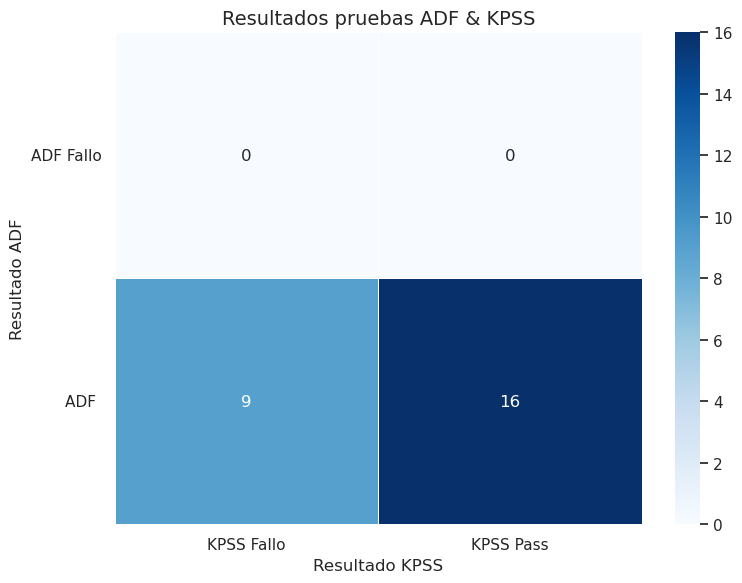

In [402]:
confusion_df = pd.DataFrame(
    result_matrix,
    index=["ADF Fallo", "ADF "],
    columns=["KPSS Fallo", "KPSS Pass"]
)

# Plot with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues", cbar=True, linewidths=0.5)

# Axis labels and title
plt.title("Resultados pruebas ADF & KPSS", fontsize=14)
plt.xlabel("Resultado KPSS", fontsize=12)
plt.ylabel("Resultado ADF", fontsize=12)

# Rotate ticks for better readability (optional)
plt.xticks(rotation=0)
plt.yticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.savefig("Images/adf_kpss.png", format = "png")
plt.show()

/tmp/ipykernel_7389/4219471498.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize = "medium", ncols = 5)


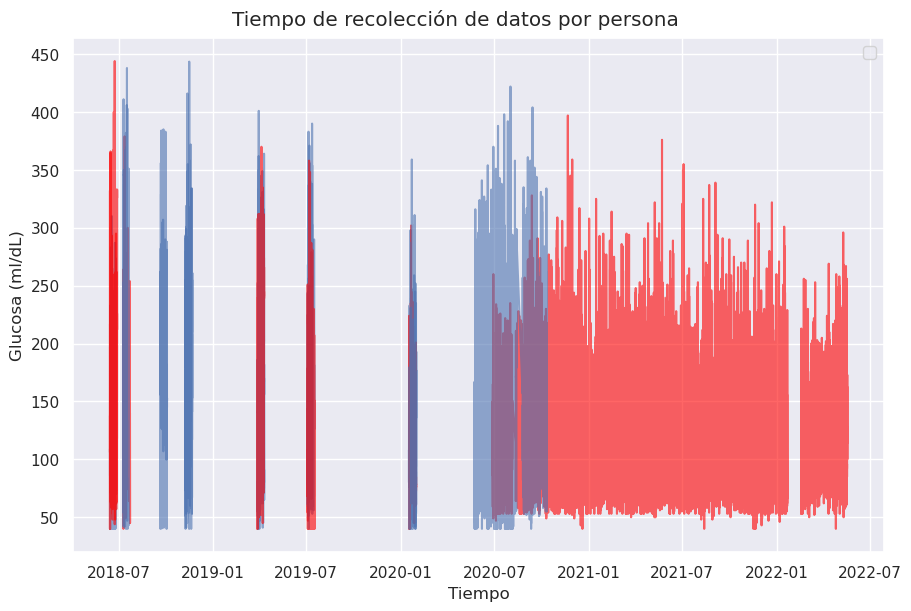

In [403]:
fig, ax = plt.subplots(figsize = (width*1.5, width), layout = "constrained")
for i, person in enumerate(people):
    if i in not_kpss:
        plt.plot(person.time, person.glucose, alpha = a, color = "red")
    else:
        plt.plot(person.time, person.glucose, alpha = a, color = deep_blue)
ax.set_ylabel("Glucosa (ml/dL)")
ax.set_xlabel("Tiempo")
fig.suptitle("Tiempo de recolección de datos por persona")
plt.legend(fontsize = "medium", ncols = 5)
plt.savefig("Images/tiempo_recoleccion_glucosa.png", format = "png")
plt.show()

In [404]:
not_kpss = [0,1,5,12,14,19, 20, 21, 23]
stationary = []
not_stationary = []
for i, person in enumerate(people):
    if i in not_kpss:
        not_stationary = np.append(not_stationary, person["glucose"])
    else:
        stationary = np.append(stationary, person["glucose"])

In [405]:
stats.ttest_ind(not_stationary, stationary, equal_var= False)

TtestResult(statistic=np.float64(-112.05617631498276), pvalue=np.float64(0.0), df=np.float64(130209.62017387418))

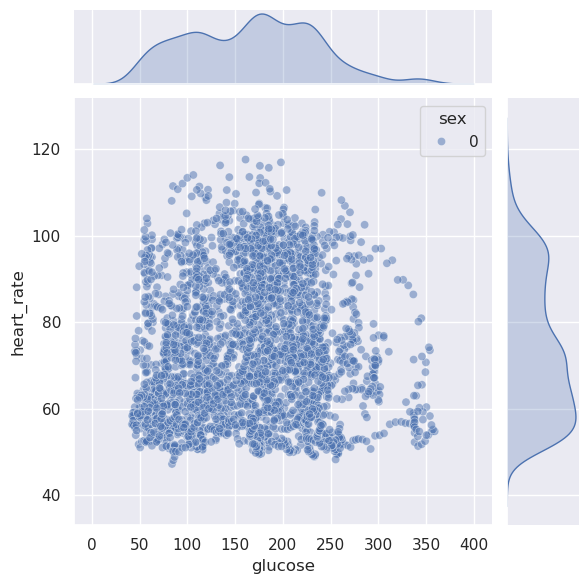

In [406]:
fig 
sns.jointplot(data = df, x = "glucose", y = "heart_rate", hue = "sex", alpha = .5)

<Axes: >

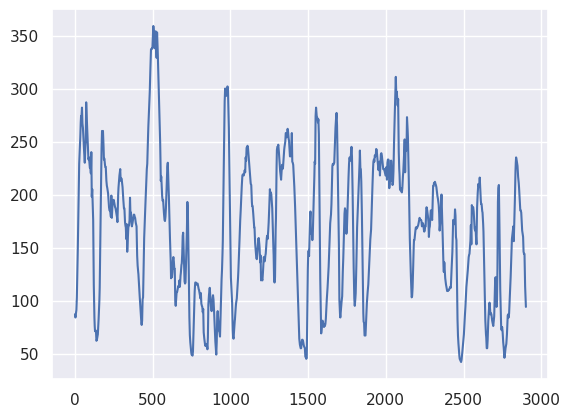

In [407]:

person["glucose"].plot()

In [408]:
mu = person["glucose"].mean()
sigma = person["glucose"].std()

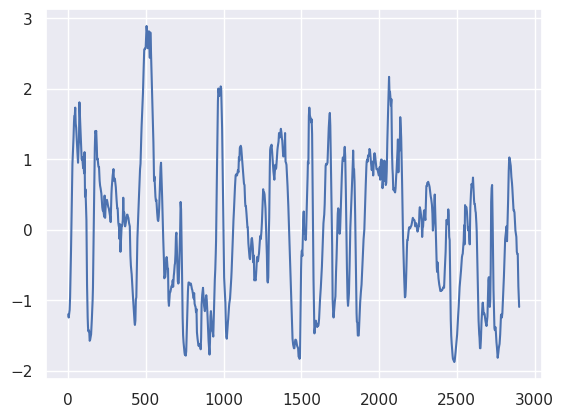

In [409]:
ts = (person["glucose"] - mu)/ sigma
plt.plot(ts)

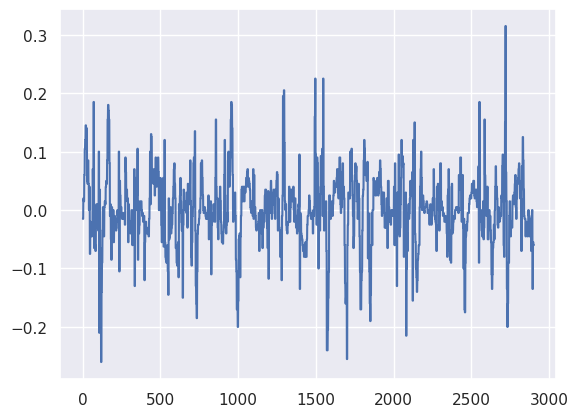

In [410]:
ts = ts.diff().dropna()
plt.plot(ts)

<Axes: >

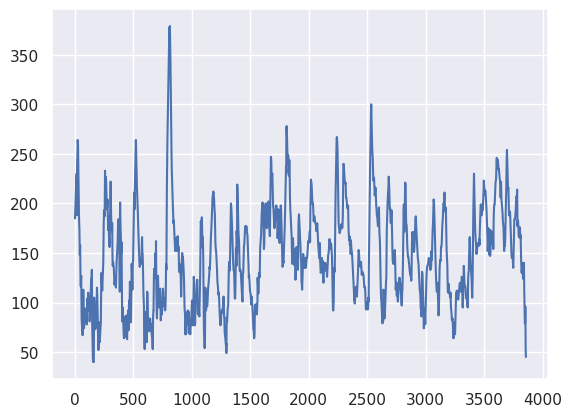

In [411]:
ts = people[0]["glucose"]
ts.plot()

<Axes: >

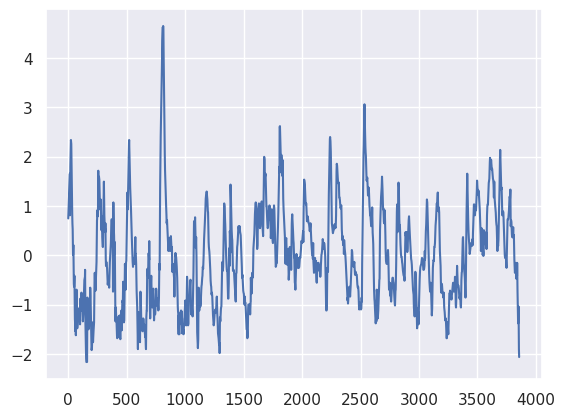

In [412]:
mu = ts.mean()
sigma = ts.std()
ts = (ts - mu) / sigma
ts.plot()

<Axes: >

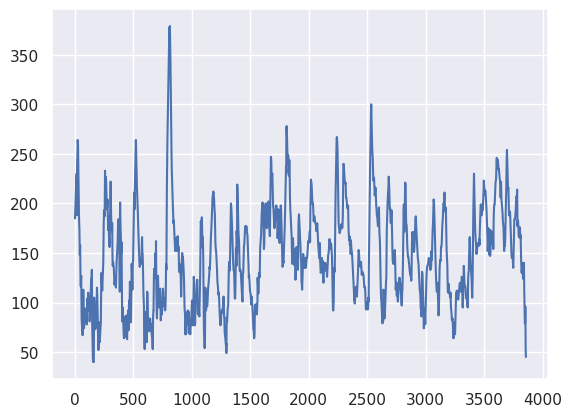

In [413]:
people[0]["glucose"].plot()

<Axes: >

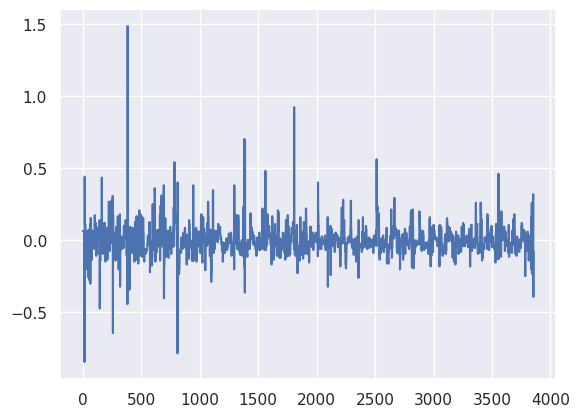

In [414]:
ts1 = ts.diff().dropna()
ts1.plot()

In [415]:
ts2 = ts.diff().dropna()

In [416]:
kpss(people[0]["glucose"], regression='c', nlags='auto')

(np.float64(0.6304246616869084),
 np.float64(0.019870485301190146),
 38,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [417]:
kpss(ts1, regression='c', nlags='auto')

/tmp/ipykernel_7389/921485068.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(ts1, regression='c', nlags='auto')


(np.float64(0.015319722656994147),
 np.float64(0.1),
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [418]:
kpss(ts, regression='c', nlags='auto')

(np.float64(0.6304246616869003),
 np.float64(0.019870485301190885),
 38,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [419]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

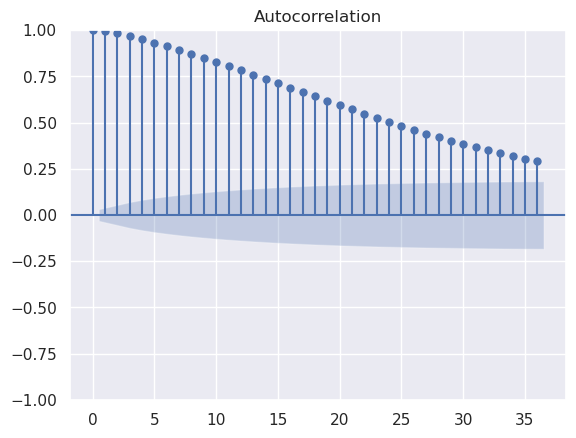

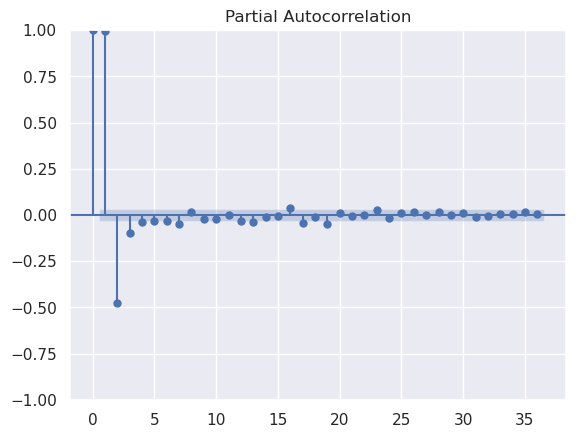

In [420]:
plot_acf(ts)
plot_pacf(ts)
plt.show()

In [421]:
from statsmodels.tsa.arima.model import ARIMA
q = 5
p = 2
d = 1
model = ARIMA(ts, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                glucose   No. Observations:                 3858
Model:                 ARIMA(2, 1, 5)   Log Likelihood                4015.012
Date:                Wed, 21 May 2025   AIC                          -8014.024
Time:                        03:55:43   BIC                          -7963.962
Sample:                             0   HQIC                         -7996.245
                               - 3858                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7218      0.494      1.462      0.144      -0.246       1.690
ar.L2         -0.0568      0.367     -0.155      0.877      -0.776       0.663
ma.L1         -0.2275      0.495     -0.460      0.6

/home/luisdogo/miniconda3/envs/tt/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
